### Stock Market Prediction And Forecasting Using Stacked LSTM

In [83]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt



#### Code to get data for nadsaq and its technical indicators

In [ ]:
# # Load or fetch NASDAQ data
# if os.path.exists("nasdaq.csv"):
#     nasdaq = pd.read_csv("nasdaq.csv")
# else:
#     nasdaq = yf.Ticker("^IXIC")
#     nasdaq = nasdaq.history(period="max")
#     nasdaq.to_csv("nasdaq.csv")

# #Technical indicators
# # Calculate technical indicators
# print("Calculating technical indicators...")
# nasdaq['EMA_50'] = ta.trend.ema_indicator(nasdaq['Close'], window=50)
# nasdaq['EMA_200'] = ta.trend.ema_indicator(nasdaq['Close'], window=200)
# nasdaq['RSI'] = ta.momentum.rsi(nasdaq['Close'])
# macd = ta.trend.MACD(nasdaq['Close'])
# nasdaq['MACD'] = macd.macd()
# nasdaq['MACD_Signal'] = macd.macd_signal()
# nasdaq['MACD_Hist'] = macd.macd_diff()

# # Filter the data starting from 1990-01-01
# nasdaq['Date'] = pd.to_datetime(nasdaq['Date'], utc=True)

# nasdaq = nasdaq[nasdaq['Date'] > '1990-01-01']

# #Removing the unwanted columns
# # del nasdaq['Dividends']
# # del nasdaq['Stock Splits']

# #save the latest file
# nasdaq.to_csv("nasdaq.csv")

In [75]:
# Load the dataset
file_path = 'nasdaq.csv'
nasdaq_data = pd.read_csv(file_path)

In [76]:
nasdaq_data.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,EMA_50,EMA_200,RSI,MACD,MACD_Signal,MACD_Hist
0,4776,1990-01-02 05:00:00+00:00,452.899994,459.299988,452.700012,459.299988,110720000,453.490768,444.839773,62.885333,-1.049759,-2.890670,1.840911
1,4777,1990-01-03 05:00:00+00:00,461.100006,461.600006,460.000000,460.899994,152660000,453.781326,444.999576,64.551665,-0.049565,-2.322449,2.272884
2,4778,1990-01-04 05:00:00+00:00,460.399994,460.799988,456.899994,459.399994,147950000,454.001666,445.142864,61.752523,0.614970,-1.734965,2.349935
3,4779,1990-01-05 05:00:00+00:00,457.899994,459.399994,457.799988,458.200012,137230000,454.166307,445.272785,59.528642,1.032884,-1.181395,2.214279
4,4780,1990-01-08 05:00:00+00:00,457.100006,458.700012,456.500000,458.700012,115500000,454.344100,445.406390,60.172252,1.388424,-0.667432,2.055856


In [77]:
nasdaq_data.tail()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,EMA_50,EMA_200,RSI,MACD,MACD_Signal,MACD_Hist
8693,13469,2024-07-08 04:00:00+00:00,18371.859375,18416.939453,18342.599609,18403.740234,5286260000,17189.750516,15675.307967,76.595822,346.377771,314.919227,31.458543
8694,13470,2024-07-09 04:00:00+00:00,18465.019531,18511.890625,18381.599609,18429.289062,4839140000,17238.359870,15702.710764,76.984401,357.604954,323.456373,34.148581
8695,13471,2024-07-10 04:00:00+00:00,18512.089844,18655.189453,18467.580078,18647.449219,5228240000,17293.618276,15732.011644,80.032922,379.729000,334.710898,45.018102
8696,13472,2024-07-11 04:00:00+00:00,18659.250000,18671.070312,18238.779297,18283.410156,6366620000,17332.433644,15757.398694,64.645599,363.695104,340.507739,23.187365
8697,13473,2024-07-12 04:00:00+00:00,18303.640625,18556.730469,18293.599609,18398.449219,5845930000,17374.238176,15783.677803,66.816775,356.165167,343.639225,12.525943


In [78]:
# Drop the unnecessary columns
df = nasdaq_data.drop(columns=['Unnamed: 0', 'Date'])


In [80]:
# Use all columns except 'Close' as features for X
features = df.columns.tolist()
features.remove('Close')

# Prepare X and Y
X = df[features].values
Y = df['Close'].values



In [81]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler
# Normalize the dataset
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y.reshape(-1, 1))

# Reshape input to be 3D [samples, time steps, features]
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, random_state=42)

#### Model Stacked LSTM for price prediction

In [82]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Predicting the 'Close' price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [84]:
# Train the model
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

# Evaluate the model
loss = model.evaluate(X_test, Y_test, verbose=1)
print(f'Test Loss: {loss}')


Epoch 1/20
218/218 [==============================] - 8s 11ms/step - loss: 0.0092 - val_loss: 2.2427e-04
Epoch 2/20
218/218 [==============================] - 1s 6ms/step - loss: 0.0013 - val_loss: 3.2115e-04
Epoch 3/20
218/218 [==============================] - 1s 6ms/step - loss: 8.9512e-04 - val_loss: 1.3436e-04
Epoch 4/20
218/218 [==============================] - 2s 8ms/step - loss: 7.9549e-04 - val_loss: 6.0706e-05
Epoch 5/20
218/218 [==============================] - 1s 6ms/step - loss: 7.2089e-04 - val_loss: 5.9161e-05
Epoch 6/20
218/218 [==============================] - 1s 5ms/step - loss: 6.5100e-04 - val_loss: 2.3838e-05
Epoch 7/20
218/218 [==============================] - 1s 4ms/step - loss: 6.6771e-04 - val_loss: 2.4667e-04
Epoch 8/20
218/218 [==============================] - 1s 5ms/step - loss: 6.1538e-04 - val_loss: 6.8096e-05
Epoch 9/20
218/218 [==============================] - 1s 4ms/step - loss: 6.0166e-04 - val_loss: 1.1323e-04
Epoch 10/20
218/218 [==============

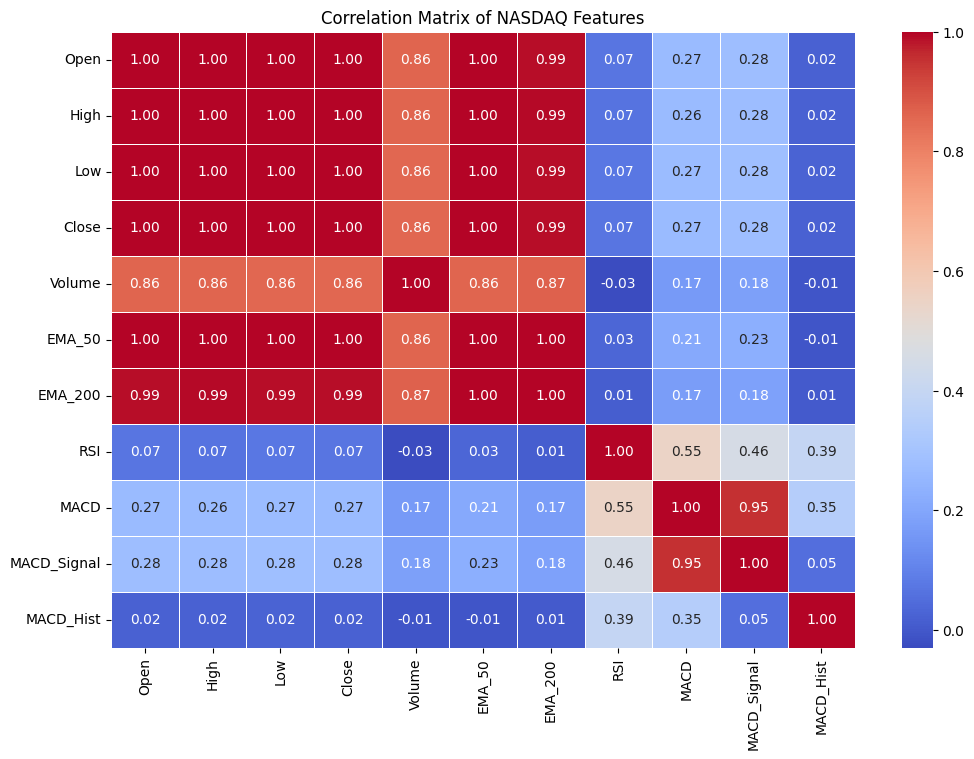

In [71]:
import seaborn as sns
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Correlation Matrix of NASDAQ Features')
plt.show()

In [68]:
X_train.shape[1], X_train.shape[2]

(1, 10)

In [73]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Make predictions
Y_pred_scaled = model.predict(X_test)

# Inverse transform the predictions and actual values
Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)
Y_actual = scaler_Y.inverse_transform(Y_test)

# Calculate MSE and RMSE
mse = mean_squared_error(Y_actual, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_actual, Y_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')


55/55 [==============================] - 0s 2ms/step
MSE: 11483.260787710038
RMSE: 107.15997754623709
MAE: 60.31025585306101


In [64]:
# Generate predictions for the next 30 days
future_predictions = []
last_sequence = X_scaled[-1]

for _ in range(30):
    # Make prediction
    next_prediction_scaled = model.predict(last_sequence.reshape(1, 1, -1))
    next_prediction = scaler_Y.inverse_transform(next_prediction_scaled)
    future_predictions.append(next_prediction[0][0])

    # Update the sequence by appending the prediction and removing the oldest entry
    last_sequence = np.append(last_sequence[:, 1:], next_prediction_scaled).reshape(1, -1)

# Prepare dates for plotting future predictions
last_date = pd.to_datetime(nasdaq_data['Date'].iloc[-1])
future_dates = [last_date + pd.DateOffset(days=i) for i in range(1, 31)]

# Combine actual and predicted data for plotting
full_dates = pd.to_datetime(nasdaq_data['Date'])
full_prices = np.append(scaler_Y.inverse_transform(Y_scaled).flatten(), future_predictions)




1/1 [==============================] - 0s 20ms/step


In [69]:
Y_actual.shape, Y_pred.shape

((1740, 1), (1740, 1))

In [70]:
Y_actual, Y_pred

(array([[9467.96972656],
        [2057.37011719],
        [4526.06005859],
        ...,
        [9129.24023438],
        [ 426.79998779],
        [4534.06005859]]),
 array([[9602.392  ],
        [2043.0474 ],
        [4631.3833 ],
        ...,
        [9351.122  ],
        [ 470.55344],
        [4498.207  ]], dtype=float32))

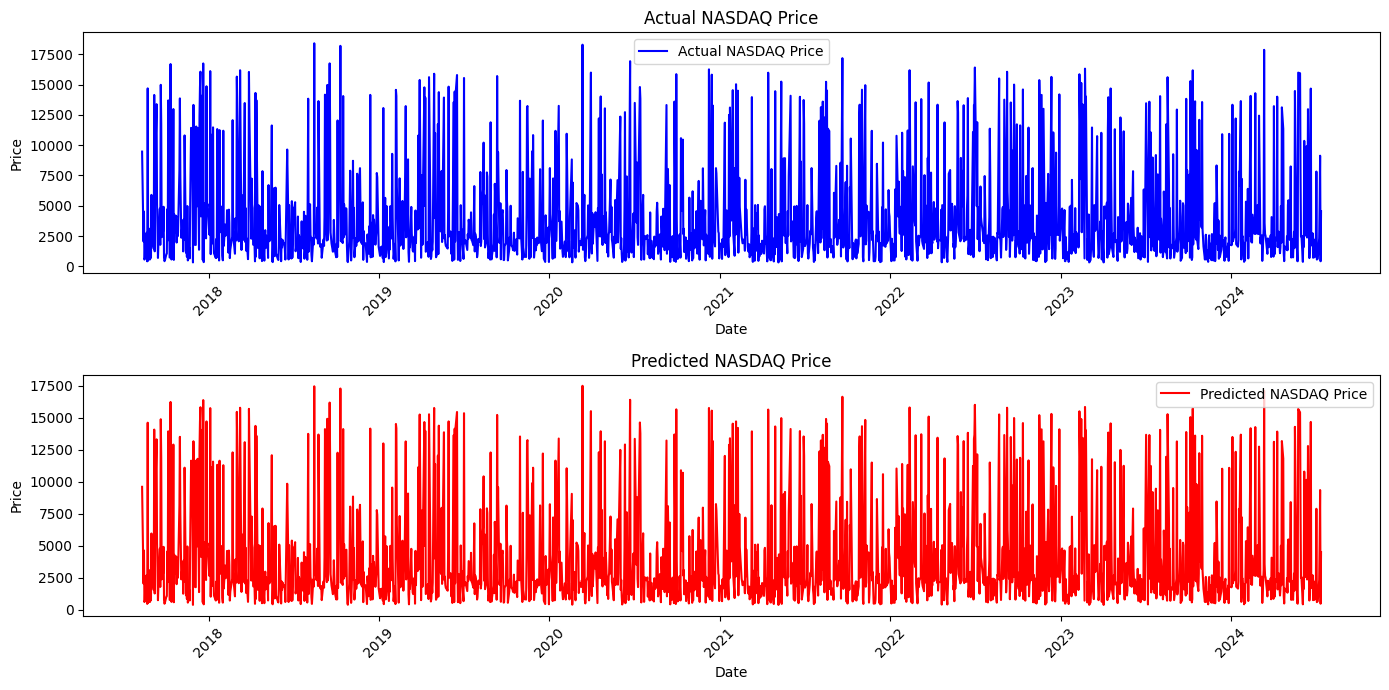

In [66]:
# Plot actual and predicted values
plt.figure(figsize=(14, 7))

# Subplot 1: Actual values
plt.subplot(2, 1, 1)
plt.plot(full_dates[-len(Y_actual):], Y_actual, color='blue', label='Actual NASDAQ Price')
plt.title('Actual NASDAQ Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)

# Subplot 2: Predicted values
plt.subplot(2, 1, 2)
plt.plot(full_dates[-len(Y_pred):], Y_pred, color='red', label='Predicted NASDAQ Price')
plt.title('Predicted NASDAQ Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

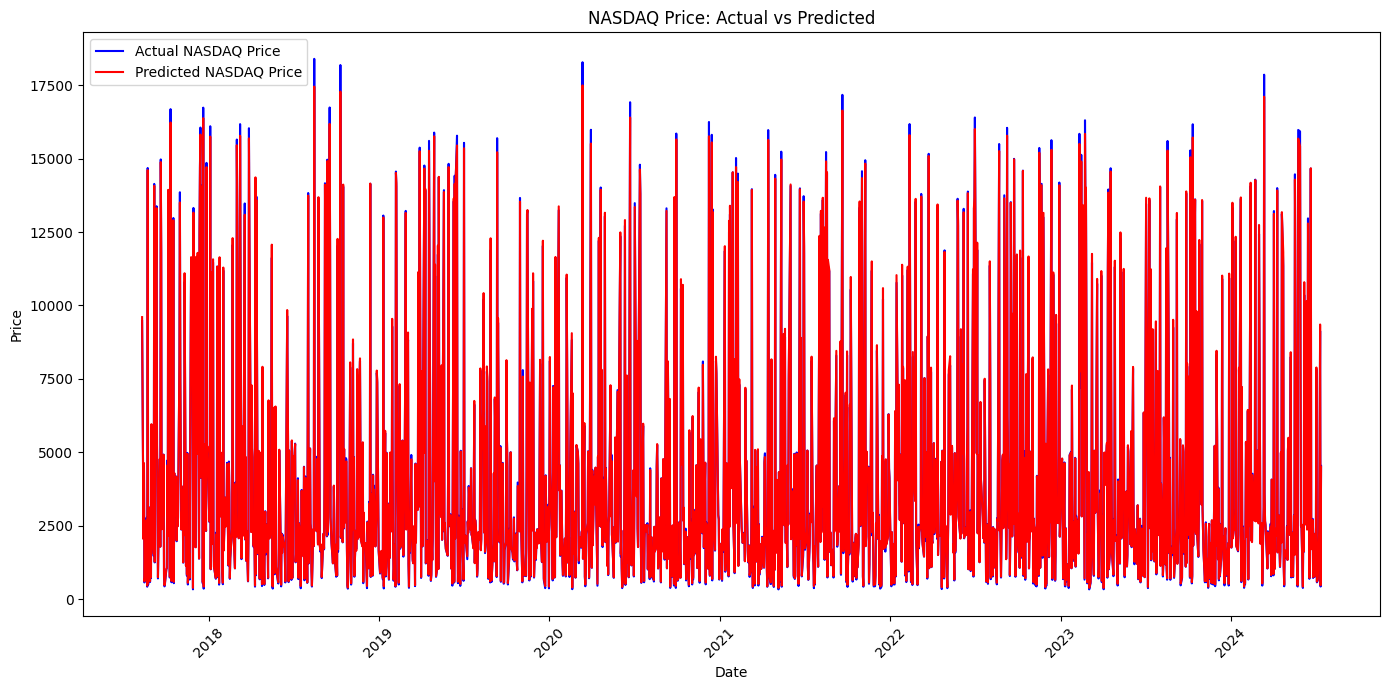

In [85]:
import matplotlib.pyplot as plt

# Create a figure
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(full_dates[-len(Y_actual):], Y_actual, color='blue', label='Actual NASDAQ Price')

# Plot predicted values
plt.plot(full_dates[-len(Y_pred):], Y_pred, color='red', label='Predicted NASDAQ Price')

# Set title, labels and legend
plt.title('NASDAQ Price: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


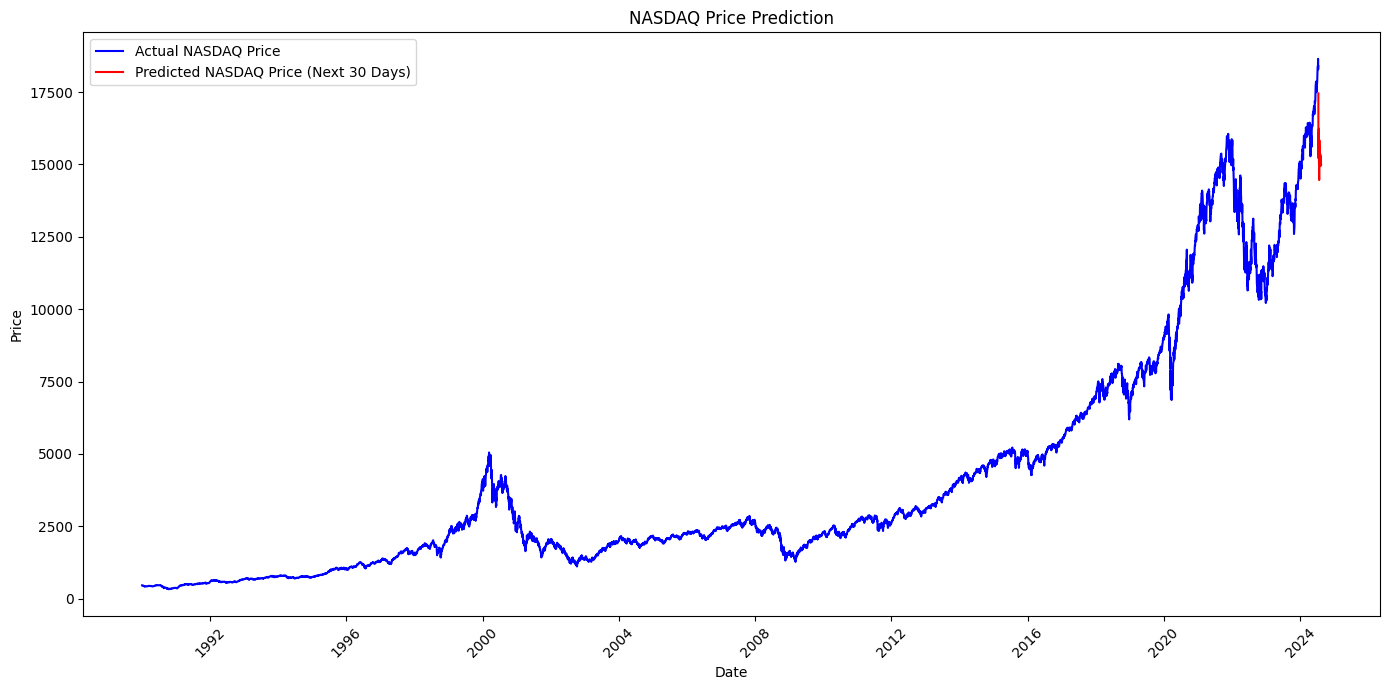

In [63]:
# Plot actual and predicted values
plt.figure(figsize=(14, 7))
plt.plot(full_dates, scaler_Y.inverse_transform(Y_scaled).flatten(), color='blue', label='Actual NASDAQ Price')
plt.plot(future_dates, future_predictions, color='red', label='Predicted NASDAQ Price (Next 30 Days)')
plt.title('NASDAQ Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
